In [1]:
import numpy as np
import cntk
from cntk import Trainer, learning_rate_schedule, UnitType
from cntk.learner import sgd
from cntk.ops import *

# 今回はCPUで実行します
cntk.device.set_default_device(cntk.device.cpu())

In [2]:
# 入力は2次元で、2つのクラスに分類する
input_dim = 2
num_output_classes = 2

In [3]:
# 実験用のデータを作成するための関数を定義します
np.random.seed(0)
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)
    X = (np.random.randn(sample_size, feature_dim) + 3) * (Y + 1)
    
    X = X.astype(np.float32)
    
    class_ind = [Y == class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y

In [4]:
# 今回は64個のサンプルデータを用意します
sample_size = 64
features, labels = generate_random_data_sample(sample_size, input_dim, num_output_classes)

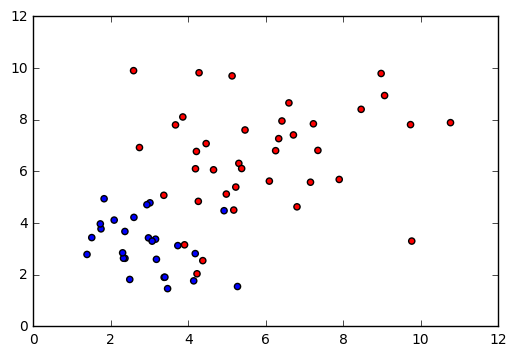

In [5]:
# 用意したデータを可視化してみます
import matplotlib.pyplot as plt
%matplotlib inline

colors=["r" if l == 0 else "b" for l in labels[:, 0]]

plt.scatter(features[:, 0], features[:, 1], c=colors)
plt.show()

In [6]:
#
# ここからモデルを構築していきます
#

# 入力の変数を定義
input = input_variable(input_dim, np.float32)

# モデルのパラメータは辞書で保持する
# wとbがそれぞれウェイトとバイアスです。
param = {"w": None, "b": None}

In [7]:
#　1層のネットワークを定義する。
# parameterを使ってwとbを定義して、xw + bの式を最後のreturnしている部分で定義しているのがわかるかと思います。
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    weight_param = parameter(shape=(input_dim, output_dim))
    bias_param = parameter(shape=(output_dim))
    param["w"], param["b"] = weight_param, bias_param
    return times(input_var, weight_param) + bias_param

output_dim = num_output_classes
z = linear_layer(input, output_dim)

In [8]:
# 損失関数はクロスエントロピー
label = input_variable((num_output_classes), np.float32)
loss = cross_entropy_with_softmax(z, label)

# 正しく分類できているかの評価
eval_error = classification_error(z, label)

In [9]:
# 学習に使うTrainerオブジェクトを用意
learning_rate = 0.1
lr_schedule = learning_rate_schedule(learning_rate, UnitType.minibatch) 
learner = sgd(z.parameters, lr_schedule)
trainer = Trainer(z, loss, eval_error, [learner])

In [10]:
# 学習の状況を表示するための関数を用意
from cntk.utils import get_train_eval_criterion, get_train_loss

# 移動平均
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# ロスや分類のエラーなどの状況を表示
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = get_train_loss(trainer)
        eval_error = get_train_eval_criterion(trainer)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

In [11]:
# 学習データのパラメータ
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [12]:
# いよいよ学習を走らせます
training_progress_output_freq = 50

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # trainerにミニバッチを与えていきます。TensorFlowのsess.run()でfeed_dictを使ってデータを与えるのと非常に似ていますね。いますね。
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.68
Minibatch: 50, Loss: 0.4191, Error: 0.20
Minibatch: 100, Loss: 0.3790, Error: 0.12
Minibatch: 150, Loss: 0.3418, Error: 0.04
Minibatch: 200, Loss: 0.3858, Error: 0.16
Minibatch: 250, Loss: 0.2826, Error: 0.08
Minibatch: 300, Loss: 0.2458, Error: 0.04
Minibatch: 350, Loss: 0.2294, Error: 0.00
Minibatch: 400, Loss: 0.3004, Error: 0.08
Minibatch: 450, Loss: 0.3086, Error: 0.12
Minibatch: 500, Loss: 0.2640, Error: 0.04
Minibatch: 550, Loss: 0.3452, Error: 0.20
Minibatch: 600, Loss: 0.3129, Error: 0.12
Minibatch: 650, Loss: 0.2016, Error: 0.12
Minibatch: 700, Loss: 0.3199, Error: 0.08
Minibatch: 750, Loss: 0.3353, Error: 0.16


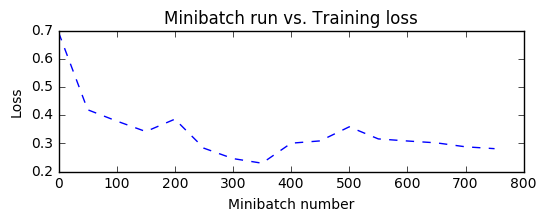

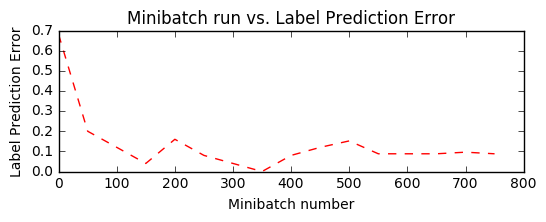

In [13]:
# 学習状況の可視化
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [14]:
# テストデータを作って走らせてみる。分類のエラーレートが得られる。
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)
trainer.test_minibatch({input : features, label : labels})

0.12

In [15]:
# 学習したモデルを使って与えられたデータからクラスを予測する
# Softmax関数を噛ませて、それぞれのクラスに属する確率にしたものを出力とする
out = softmax(z)
result = out.eval({input : features})

In [16]:
# 実際のラベルと、モデルが予測したラベルの比較
print("Label    :", np.argmax(labels[:25],axis=1))
print("Predicted:", np.argmax(result[:25, 0, :],axis=1))

Label    : [1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1]
Predicted: [1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1]


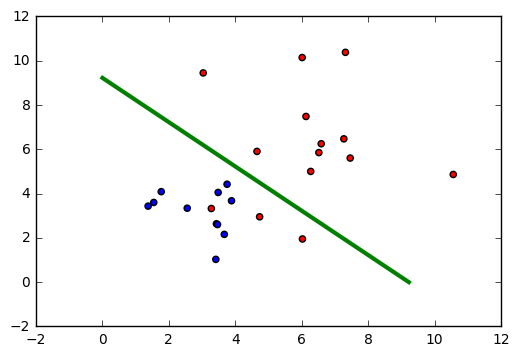

In [17]:
# 学習結果を可視化
bias_vector   = param['b'].value
weight_matrix = param['w'].value

colors = ['r' if l == 0 else 'b' for l in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.show()